<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/vgg-transfer-learning/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [2]:
#Hello World
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [5]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [6]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [7]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
USE_CROPPED_IMAGES = False
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 16
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks


train_data, val_data, test_data = DataLoader.load_datasets()
for record in val_data.take(1):
  print(record[0].shape, record[1].shape)

(450, 450, 3) (136,)


## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [ ]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [ ]:
INPUT_SHAPE = (450,450,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 128)    

In [ ]:
basic_model.fit(train_data.batch(64), epochs=30, validation_data=val_data, verbose=1)

Epoch 1/30
     24/Unknown - 27s 1s/step - loss: 0.2102 - accuracy: 0.1131

KeyboardInterrupt: ignored

### Analyze Results

In [ ]:
pd.DataFrame(basic_model.history.history).plot()

In [ ]:
predictions = basic_model.predict(test_data.map(lambda x,y: x))

In [ ]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1

## VGG Transfer Learning
What if we took VGG model and used it to process the image.

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [15]:
def create_vgg_landmark_model(input_shape):
  vgg = VGG16(include_top=False, input_shape=input_shape)
  for layer in vgg.layers:
    layer.trainable = False
  x = layers.Flatten()(vgg.output)
  x = layers.Dense(512, activation="tanh")(x)
  x = layers.Dense(256, activation="tanh")(x)
  x = layers.Dense(68*2, activation="tanh")(x)

  return Model(name="vgg_landmark_net", inputs=vgg.input, outputs=x)

In [16]:
vgg_landmark_net = create_vgg_landmark_model((450,450,3))
vgg_landmark_net.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
vgg_landmark_net.summary()

Model: "vgg_landmark_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 450, 450, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 450, 450, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 225, 225, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 225, 225, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 225, 225, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)

In [17]:
def preprocess_vgg(img, landmarks):
  rescaled_image =  (img + 1)/ 2 *255
  return (preprocess_input(rescaled_image), landmarks)


vgg_train = train_data.map(preprocess_vgg)
vgg_validation = val_data.map(preprocess_vgg)
vgg_landmark_net.fit(vgg_train.batch(64), epochs=50, batch_size=64)

Epoch 1/50
26/26 [==============================] - 70s 2s/step - loss: 0.0609 - accuracy: 6.1538e-04
Epoch 2/50
26/26 [==============================] - 26s 974ms/step - loss: 0.0066 - accuracy: 0.0000e+00
Epoch 3/50
26/26 [==============================] - 26s 965ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 4/50
26/26 [==============================] - 26s 969ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Epoch 5/50
26/26 [==============================] - 26s 974ms/step - loss: 0.0019 - accuracy: 0.4345
Epoch 6/50
26/26 [==============================] - 26s 975ms/step - loss: 0.0017 - accuracy: 0.5926
Epoch 7/50
26/26 [==============================] - 26s 974ms/step - loss: 0.0016 - accuracy: 0.6388
Epoch 8/50
26/26 [==============================] - 26s 975ms/step - loss: 0.0016 - accuracy: 0.6455
Epoch 9/50
26/26 [==============================] - 26s 973ms/step - loss: 0.0016 - accuracy: 0.6480
Epoch 10/50
26/26 [==============================] - 26s 975ms/step - loss: 0.

In [26]:
vgg_landmark_net.save(os.path.join(PROJECT_FILEPATH, "models", "VGG.h5"))

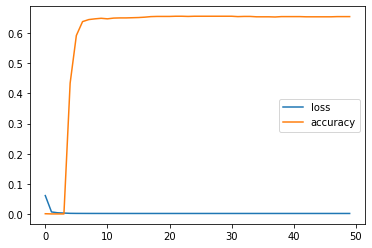

In [18]:
pd.DataFrame(vgg_landmark_net.history.history).plot()

In [19]:
predictions = vgg_landmark_net.predict(test_data.map(preprocess_vgg).map(lambda img, _ : img).batch(64).take(1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


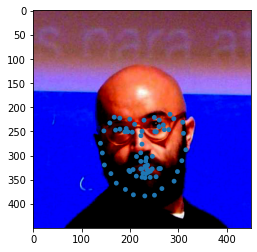

In [28]:
#@title View Predicted Images
image_index = 4 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1